# Semi-discrete optimal Transport with Curvling Demo
_______________________________
In this tutorial, you will be taught how to manipulate our toolbox for computing the optimal transport between a image and a mesure carried by a curve with bounded speed and acceleration discretized by a set of Dirac masses.

## Computation of the classical semi-discrete bluenoise problem
___________________

In this section we load all the libraries that allows to compute the 2-Wasserstein distance between an image and a set Dirac masses.

In [1]:
# import all the required libraries
import numpy as np
import scipy.sparse as sps
import matplotlib.pyplot as plt
from PIL import Image
import PIL

from OTInterface import OT,calcul_masse
from optim import optimalTransportHessLM,optimalTransportHess

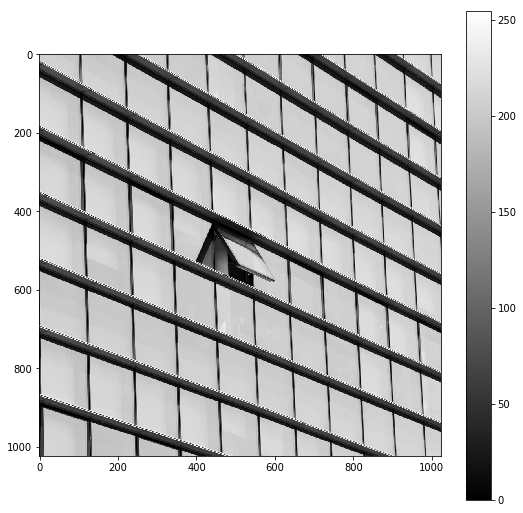

In [2]:
# import the reference image
u = Image.open('window.jpg').convert('L')
u.load()
u = u.resize((1024,1024),PIL.Image.ANTIALIAS)
u = np.array(u,dtype=float)
img = u.copy()
plt.figure(1,figsize=(9,9))
plt.imshow(u,cmap="gray");
plt.colorbar()
u = np.max(u) - u + 3

In [3]:
isQ1 = True
# normalize image
u = u /calcul_masse(u,isQ1)
# initialize the optimal transport toolbox
box = [0.0,1.0,0.0,1.0]
ot = OT(np.rot90(u,3),box,isQ1)

In [4]:
# initialize Dirac mass position
x = np.random.rand(10000,2)
psi = np.zeros(x.shape[0])
w = np.ones_like(psi)
w /= np.sum(w)
#optimize Dirac mass position using the most commonly used damped Newton algorithm
import time;
timeNewton = time.time()
for i in range(8):
    psi,M,Bar,Cost = optimalTransportHess(ot,psi,x,w,1e-6,15)
    x = Bar
    psi *= 0
timeNewton = time.time() - timeNewton

   itt 	      CF             ||Grad||          alpha 	    flag        hidden  
--------------------------------------------------------------------------------------
    0    -3.184238e-05      9.185194e-03     -1.000e+00
    1    -1.111238e-04      8.553379e-03     6.25e-02 	 	 0        0   
    2    -1.777016e-04      7.980341e-03     6.25e-02 	 	 0        0   
    3    -2.336109e-04      7.458053e-03     6.25e-02 	 	 0        0   
    4    -3.249276e-04      6.486847e-03     1.25e-01 	 	 0        0   
    5    -3.895109e-04      5.665903e-03     1.25e-01 	 	 0        0   
    6    -4.367186e-04      4.951213e-03     1.25e-01 	 	 0        0   
    7    -5.012581e-04      3.775076e-03     2.50e-01 	 	 0        0   
    8    -5.351919e-04      2.851133e-03     2.50e-01 	 	 0        0   
    9    -5.666765e-04      1.685279e-03     5.00e-01 	 	 0        0   
   10    -5.766570e-04      7.727047e-04     1.00e+00 	 	 0        0   
   11    -5.767267e-04      4.341117e-04     5.00e-01 	 	 

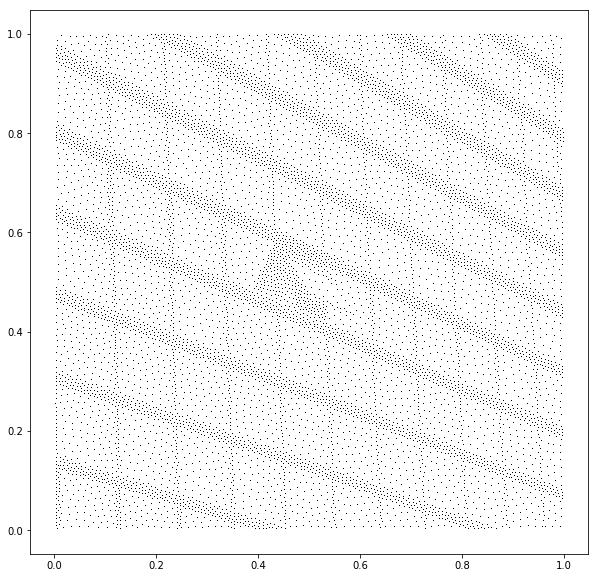

In [5]:
plt.figure(1,figsize=(10,10))
plt.plot(x[:,0],x[:,1],',k',markersize=3);

In [6]:
# initialize Dirac mass position
x = np.random.rand(10000,2)
psi = np.zeros(x.shape[0])
w = np.ones_like(psi)
w /= np.sum(w)
#optimize Dirac mass position using a Levenberg-Marquardt implementation
timeLM = time.time()
for i in range(8):
    psi,m,Bar,Cost,iternumber,gradList = optimalTransportHessLM(ot,psi,x,w,1e-6,15,verbose=True,nbiter=True)
    x = Bar
    psi *= 0
timeLM = time.time() - timeLM

  iteration :   0  CF : -3.247903e-05  ||Grad||2 : 9.134841e-03  nbHidden :   0 c : 1.504e+00
  iteration :   1  CF : -4.040647e-05  ||Grad||2 : 7.917943e-03  nbHidden :   0 c : 8.503e+00 s=1.55
  iteration :   2  CF : -5.053322e-05  ||Grad||2 : 6.871125e-03  nbHidden :   0 c : 5.002e+00 s=0.50
  iteration :   3  CF : -6.346489e-05  ||Grad||2 : 5.944639e-03  nbHidden :   0 c : 2.942e+00 s=0.54
  iteration :   4  CF : -7.972238e-05  ||Grad||2 : 5.093845e-03  nbHidden :   0 c : 1.731e+00 s=0.52
  iteration :   5  CF : -9.951025e-05  ||Grad||2 : 4.292908e-03  nbHidden :   0 c : 1.018e+00 s=0.53
  iteration :   6  CF : -1.223511e-04  ||Grad||2 : 3.517169e-03  nbHidden :   0 c : 5.989e-01 s=0.52
  iteration :   7  CF : -1.465871e-04  ||Grad||2 : 2.772827e-03  nbHidden :   0 c : 3.523e-01 s=0.53
  iteration :   8  CF : -1.696129e-04  ||Grad||2 : 2.078720e-03  nbHidden :   0 c : 2.072e-01 s=0.52
  iteration :   9  CF : -1.892723e-04  ||Grad||2 : 1.499147e-03  nbHidden :   0 c : 1.219e-01 s=0.

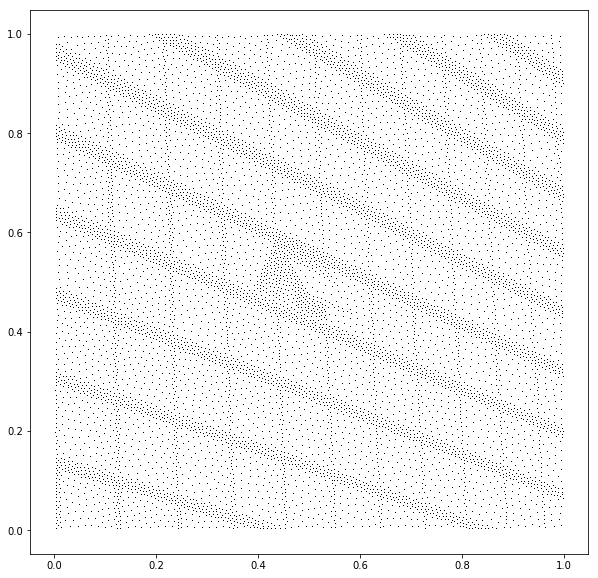

In [7]:
plt.figure(1,figsize=(10,10))
plt.plot(x[:,0],x[:,1],',k',markersize=3);

In [8]:
print(" Time damped Newton method: %3.2fs, time Levenberg-Marquardt: %3.2fs"%(timeNewton,timeLM))

 Time damped Newton method: 54.59s, time Levenberg-Marquardt: 37.50s


## Adding some constraint on the Dirac masses' position
____________________
In order to get a cinematically admissible curve one should define sets of constraints and corresponding projectors as described [in](https://arxiv.org/abs/1804.08356).

In a nutshell, this method consists in computing the discrete derivatives of the points list (with discrete finite elements operators), and if their norms are above a certain threshold we project the points back to the admissible set of points with a bounded speed and curvature via an ADMM algorithm.

The following algorithm is multi-scaled, in the begining it is computing optimal transport and optimizing the Dirac masses positions for a coarse discretization (few points), then at each mutliscale step the number of points is doubled by performing a straightforward linear interpolation.

################################################################################
################################################################################
################################## RES = 8/8 ###################################
################################################################################
################################################################################
Immediate convergency |z-proj(z)| : 0.00e+00  |z| : 9.80e-02, bnds=[0.2% (2.31e-02),5.0%  (1.31e+00)] 
interation = 1 / 8
  iteration :   0  CF : -3.688277e-02  ||Grad||2 : 1.673909e-02  nbHidden :   0 c : 7.457e-01
  iteration :   1  CF : -3.711735e-02  ||Grad||2 : 9.273159e-03  nbHidden :   0 c : 4.387e-01 s=0.24
  iteration :   2  CF : -3.725646e-02  ||Grad||2 : 5.466009e-03  nbHidden :   0 c : 2.580e-01 s=0.22
  iteration :   3  CF : -3.733451e-02  ||Grad||2 : 3.072227e-03  nbHidden :   0 c : 1.518e-01 s=0.20
  iteration :   4  CF : -3.739145e-02  ||Grad||2 : 2.464465e-03  nbHidden : 

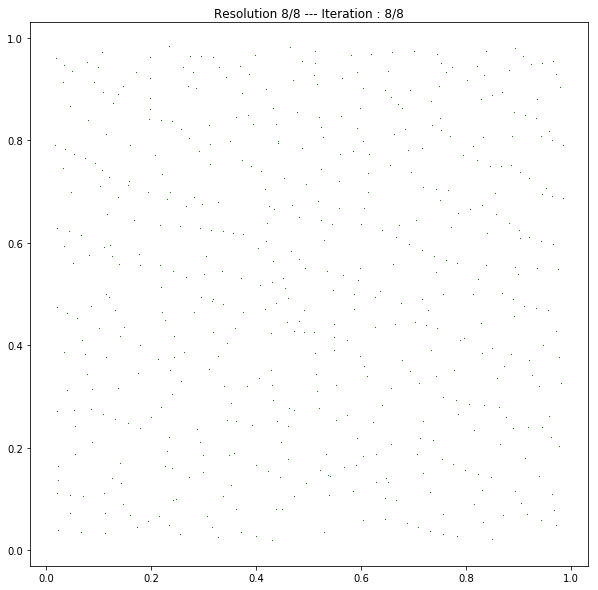

################################################################################
################################################################################
################################## RES = 7/8 ###################################
################################################################################
################################################################################
Immediate convergency |z-proj(z)| : 0.00e+00  |z| : 6.25e-01, bnds=[5.9% (3.53e+01),2.5%  (6.53e-01)] 
interation = 1 / 8
  iteration :   0  CF : -3.977023e-04  ||Grad||2 : 1.589491e-02  nbHidden :   0 c : 8.540e-02
  iteration :   1  CF : -4.847318e-04  ||Grad||2 : 1.028015e-02  nbHidden :   0 c : 5.023e-02 s=0.08
  iteration :   2  CF : -5.004229e-04  ||Grad||2 : 2.956550e-03  nbHidden :   0 c : 2.955e-02 s=0.07
  iteration :   3  CF : -5.017263e-04  ||Grad||2 : 1.307610e-03  nbHidden :   0 c : 1.738e-02 s=0.08
  iteration :   4  CF : -5.019516e-04  ||Grad||2 : 1.145004e-04  nbHidden : 

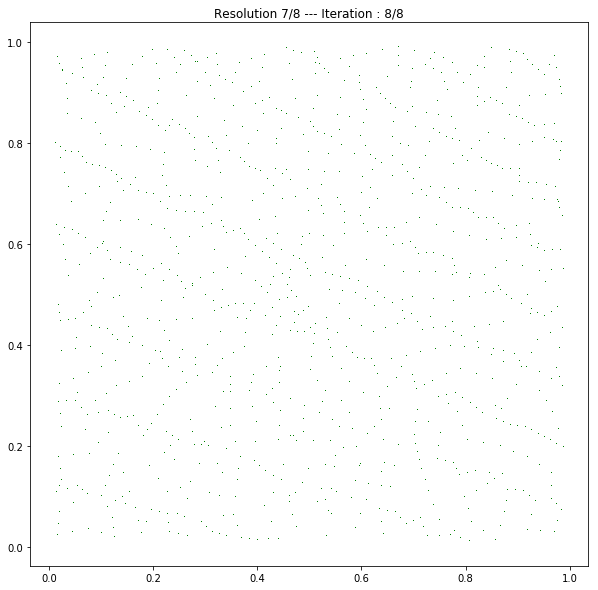

################################################################################
################################################################################
################################## RES = 6/8 ###################################
################################################################################
################################################################################
Immediate convergency |z-proj(z)| : 0.00e+00  |z| : 5.10e-01, bnds=[7.0% (3.53e+01),1.2%  (3.26e-01)] 
interation = 1 / 8
  iteration :   0  CF : -1.961296e-04  ||Grad||2 : 9.125596e-03  nbHidden :   0 c : 5.225e-01
  iteration :   1  CF : -2.239824e-04  ||Grad||2 : 2.855584e-03  nbHidden :   0 c : 3.074e-01 s=0.11
  iteration :   2  CF : -2.266395e-04  ||Grad||2 : 4.636605e-04  nbHidden :   0 c : 1.808e-01 s=0.12
  iteration :   3  CF : -2.269534e-04  ||Grad||2 : 1.393368e-04  nbHidden :   0 c : 1.064e-01 s=0.12
  iteration :   4  CF : -2.270532e-04  ||Grad||2 : 6.576207e-05  nbHidden : 

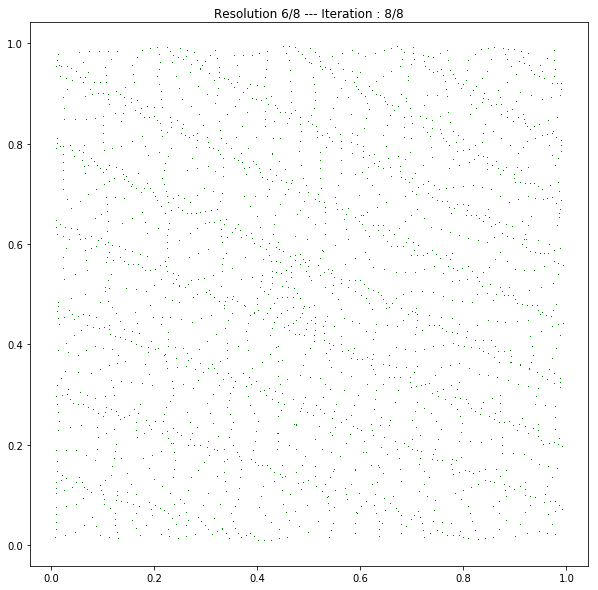

################################################################################
################################################################################
################################## RES = 5/8 ###################################
################################################################################
################################################################################
Immediate convergency |z-proj(z)| : 0.00e+00  |z| : 4.40e-01, bnds=[8.9% (5.21e+01),0.6%  (1.63e-01)] 
interation = 1 / 8
  iteration :   0  CF : -1.025574e-04  ||Grad||2 : 5.345249e-03  nbHidden :   0 c : 2.727e-01
  iteration :   1  CF : -1.078835e-04  ||Grad||2 : 2.213218e-03  nbHidden :   0 c : 1.541e+00 s=0.51
  iteration :   2  CF : -1.095729e-04  ||Grad||2 : 9.992445e-04  nbHidden :   0 c : 9.066e-01 s=0.16
  iteration :   3  CF : -1.102425e-04  ||Grad||2 : 4.944150e-04  nbHidden :   0 c : 5.333e-01 s=0.17
  iteration :   4  CF : -1.105161e-04  ||Grad||2 : 2.393934e-04  nbHidden : 

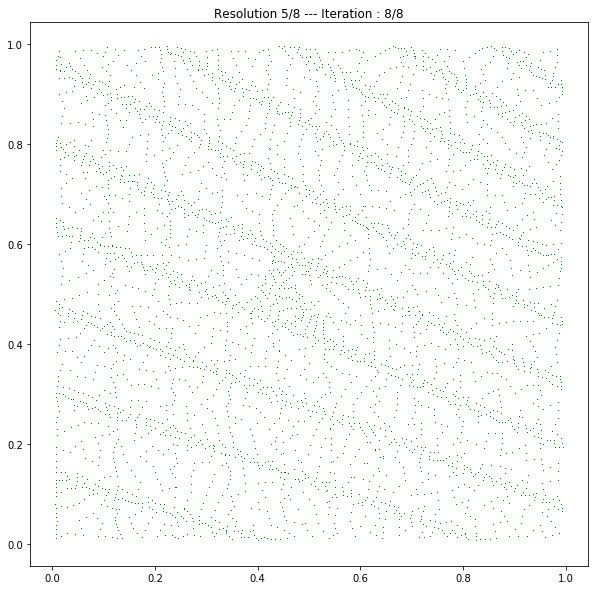

################################################################################
################################################################################
################################## RES = 4/8 ###################################
################################################################################
################################################################################
Immediate convergency |z-proj(z)| : 0.00e+00  |z| : 4.06e-01, bnds=[11.1% (6.36e+01),0.3%  (8.16e-02)] 
interation = 1 / 8
  iteration :   0  CF : -5.276253e-05  ||Grad||2 : 3.437909e-03  nbHidden :   0 c : 2.611e-01
  iteration :   1  CF : -5.548224e-05  ||Grad||2 : 8.396977e-04  nbHidden :   0 c : 1.536e-01 s=0.26
  iteration :   2  CF : -5.562506e-05  ||Grad||2 : 9.152614e-05  nbHidden :   0 c : 9.035e-02 s=0.27
  iteration :   3  CF : -5.563451e-05  ||Grad||2 : 1.706949e-05  nbHidden :   0 c : 5.314e-02 s=0.26
Immediate convergency |z-proj(z)| : 0.00e+00  |z| : 4.95e-01, bnds=[14.9% (

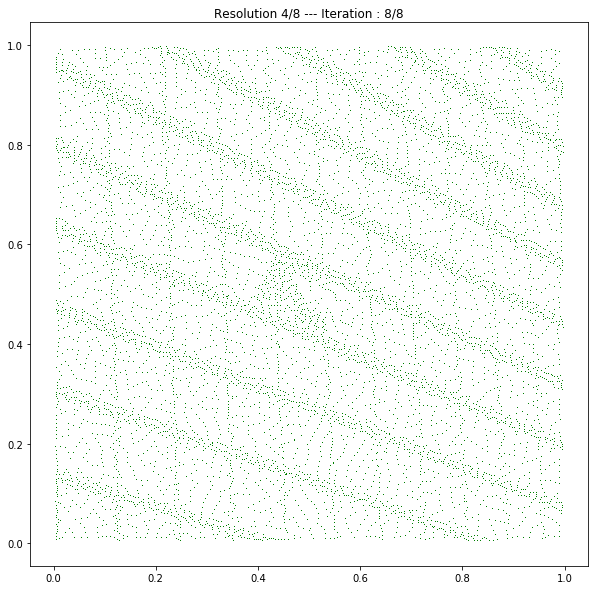

################################################################################
################################################################################
################################## RES = 3/8 ###################################
################################################################################
################################################################################
Immediate convergency |z-proj(z)| : 0.00e+00  |z| : 3.93e-01, bnds=[15.8% (7.61e+01),0.2%  (4.08e-02)] 
interation = 1 / 8
  iteration :   0  CF : -2.670827e-05  ||Grad||2 : 2.251744e-03  nbHidden :   0 c : 5.584e-01
  iteration :   1  CF : -2.778767e-05  ||Grad||2 : 4.113295e-04  nbHidden :   0 c : 3.285e-01 s=0.43
  iteration :   2  CF : -2.785948e-05  ||Grad||2 : 8.493659e-05  nbHidden :   0 c : 1.932e-01 s=0.44
  iteration :   3  CF : -2.787309e-05  ||Grad||2 : 3.058921e-05  nbHidden :   0 c : 1.137e-01 s=0.44
  iteration :   4  CF : -2.787693e-05  ||Grad||2 : 1.250123e-05  nbHidden :

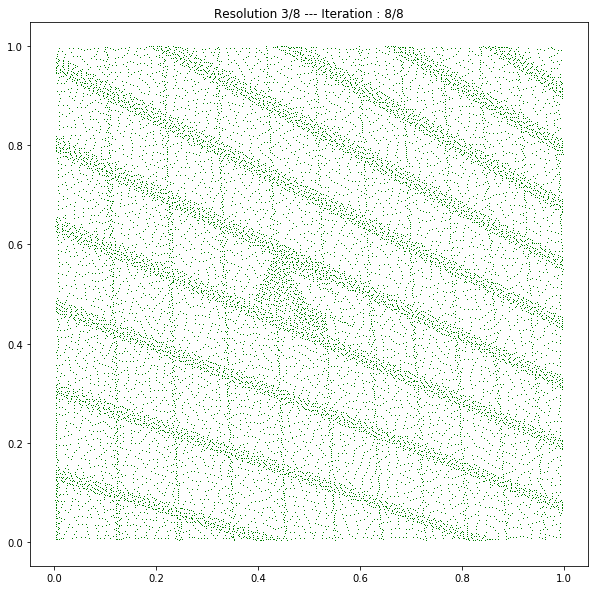

################################################################################
################################################################################
################################## RES = 2/8 ###################################
################################################################################
################################################################################
Immediate convergency |z-proj(z)| : 0.00e+00  |z| : 3.91e-01, bnds=[17.0% (9.64e+01),0.1%  (2.04e-02)] 
interation = 1 / 8
  iteration :   0  CF : -1.346553e-05  ||Grad||2 : 1.492222e-03  nbHidden :   0 c : 6.798e-01
  iteration :   1  CF : -1.392222e-05  ||Grad||2 : 2.547742e-04  nbHidden :   0 c : 3.999e-01 s=0.74
  iteration :   2  CF : -1.395713e-05  ||Grad||2 : 6.415376e-05  nbHidden :   0 c : 2.352e-01 s=0.73
  iteration :   3  CF : -1.396532e-05  ||Grad||2 : 2.728873e-05  nbHidden :   0 c : 1.384e-01 s=0.74
  iteration :   4  CF : -1.396857e-05  ||Grad||2 : 1.356076e-05  nbHidden :

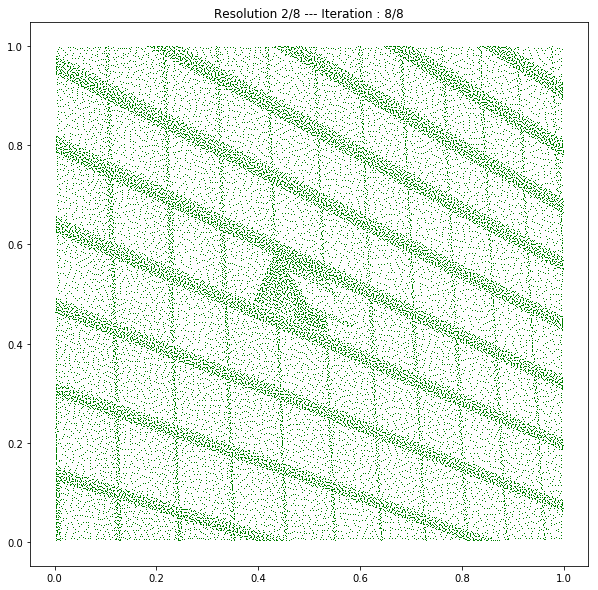

################################################################################
################################################################################
################################## RES = 1/8 ###################################
################################################################################
################################################################################
 niter :    0  distance : 0.00e+00 --- evol(L) :0.00e+00 ---- evol(x) :0.00e+00 bnds=[23.9% (3.91e-02),100.9%  (1.02e-02)]
######### niter :   31 CONVERGENCE --- distance : 1.93e-04 --- Lagrange :6.86e-06 ---- x :1.13e-11 [2.39e+01,1.00e+02]##########
interation = 1 / 8
  iteration :   0  CF : -6.776162e-06  ||Grad||2 : 9.689605e-04  nbHidden :   0 c : 4.489e-01
  iteration :   1  CF : -6.972893e-06  ||Grad||2 : 1.343045e-04  nbHidden :   0 c : 2.641e-01 s=1.31
  iteration :   2  CF : -6.983930e-06  ||Grad||2 : 2.882657e-05  nbHidden :   0 c : 1.553e-01 s=1.32
  iteration :   3  CF : -6.9

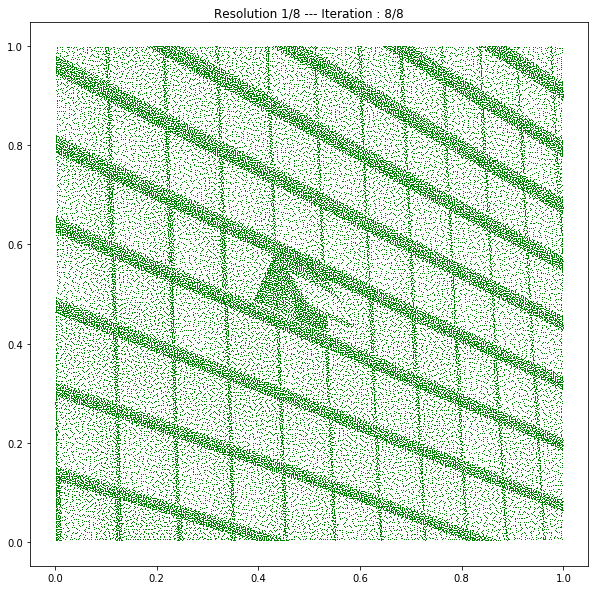

################################################################################
################################################################################
################################## RES = 0/8 ###################################
################################################################################
################################################################################
 niter :    0  distance : 0.00e+00 --- evol(L) :0.00e+00 ---- evol(x) :0.00e+00 bnds=[33.1% (1.95e-02),102.1%  (5.10e-03)]
######### niter :   30 CONVERGENCE --- distance : 6.91e-04 --- Lagrange :9.91e-06 ---- x :3.57e-11 [3.31e+01,1.00e+02]##########
interation = 1 / 8
  iteration :   0  CF : -3.526169e-06  ||Grad||2 : 6.610513e-04  nbHidden :   0 c : 4.052e-01
  iteration :   1  CF : -3.617212e-06  ||Grad||2 : 8.439100e-05  nbHidden :   0 c : 2.384e-01 s=2.47
  iteration :   2  CF : -3.622613e-06  ||Grad||2 : 1.958037e-05  nbHidden :   0 c : 1.402e-01 s=2.51
 niter :    0  distance : 0.

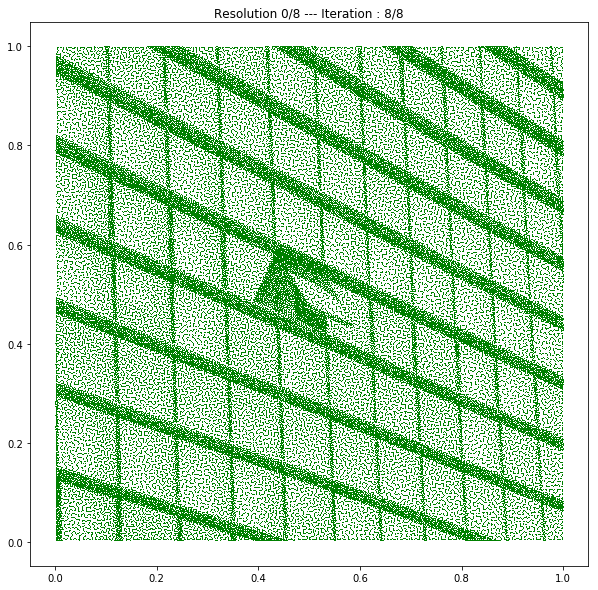

In [9]:
from Admm import admm,proj_inf_inf,mat_deriv,mat_deriv2,verif_inf_inf


def upSampleByTwo(x,psi):
    xRes = np.zeros((2*x.shape[0],x.shape[1]))
    psiRes= np.zeros((2*x.shape[0]))
    n = x.shape[0]
    for i in range(x.shape[0]-1):
        xRes[2*i,:] = x[i,:]
        d=np.array([[x[i+1,1]-x[i,1]],[x[i,0]-x[i+1,0]]])
        xRes[2*i+1,:] = .5*(x[i,:]+x[i+1,:])+1.e-2*(2*np.random.rand(1)-1)*np.squeeze(d)
        psiRes[2*i]=psi[i]
        psiRes[2*i+1]=0.5*(psi[i]+psi[i+1])	
    xRes[-2,:] = x[-1,:]
    xRes[-1,:] = (x[-1,:] + x[0,:])*.5
    psiRes[-2] = psi[-1]
    psiRes[-1] = (psi[-1] + psi[0])*.5
    return xRes,psiRes


VERBOSE=2
n = 256*256
#parametres de contrainte
c = 5.0 #c in [1/4,10]
alpha1 = c/np.sqrt(float(n))
thetamax = 2.0*np.pi/24.0
alpha2 = np.sqrt(2.0)*alpha1*np.sqrt(1.0-np.cos(thetamax))

#number of multiscale interations
resMax = 8
nn = int(n/np.power(2.0,resMax))
t = np.linspace(0,2*np.pi,nn,endpoint=False)
x = np.zeros((nn,2))
x[:,0] = np.cos(t) 
x[:,1] = np.sin(t)
x *= 0.50
x += .5

niteration = 8
k=resMax
box = [0.0,1.0,0.0,1.0]
ot = OT(np.rot90(u,3),box,isQ1)

while k >-1 :
    totalIterOT = 0
    i=0
    print("".center(80,'#'))
    print("".center(80,'#'))
    print(" RES = %i/%i ".center(82,'#') %(k,resMax))	
    print("".center(80,'#'))
    print("".center(80,'#'))
    nn = x.shape[0]
    w = np.ones(nn)
    w /= np.sum(w)
    if k==resMax : 
        psi=np.zeros(nn)    
    # Initialisation of ADMM
    projectors=[proj_inf_inf,proj_inf_inf]
    verificators=[verif_inf_inf,verif_inf_inf]
    multipliers=[1./2.,1./4.]
    bounds=[alpha1*2**k,alpha2*2**k]
    matrices=[mat_deriv(nn),mat_deriv2(nn)]
    Admm=admm((nn,2),matrices,projectors,multipliers,metric=sps.eye(nn),verificators=verificators,solver='factorize')
    # ADMM created
    gradTol = 2.1e-5
    iterMax = 2000
    xBuff=np.copy(x)
    x,res = Admm.solve(xBuff,bounds,nitermax=500,xInit=xBuff,tol=1.e-5,verbose=VERBOSE)
    # resultat de l admm
    
    x = np.minimum(1-1e-13,x)
    x = np.maximum(0+1e-13,x)

    while i <niteration :
        print("interation = %i / %i" %(i+1,niteration))
        if k==resMax :
            psi = np.zeros(nn)
        t = time.time()
        psi,m,Bar,Cost,iternumber,gradList = optimalTransportHessLM(ot,psi,x,w,gradTol,iterMax,verbose=True,nbiter=True)
        totalIterOT += iternumber
        wh = np.where(np.logical_or(Bar<0,Bar>1))
        Bar[wh[0],:] = x[wh[0],:]
        timeLM = time.time() - t
        NonEmpty = np.where(m>0)[0]	
        grad=np.zeros(x.shape)
        grad[NonEmpty] = x[NonEmpty,:] - Bar[NonEmpty,:]
        #grad=x-Bar
        tau = 1.0
        xBuff=np.copy(x-tau*grad)
        t = time.time()
        x,res = Admm.solve(xBuff,bounds,nitermax=2000,xInit=xBuff,tol=1.e-5,verbose=VERBOSE)
        timeADMM = time.time() -t
        i+=1
    k-=1
    x,psi=upSampleByTwo(x,psi)
    psi *= 0
    plt.figure(1,figsize=(10,10))
    plt.plot(x[:,0],x[:,1],',g',markersize=0.5)
    plt.title('Resolution ' + str(k+1) + '/'+str(resMax)+ ' --- Iteration : '+str(i)+'/'+str(niteration))
    plt.show(block=False)
    plt.pause(.01)
